In [1]:
%matplotlib notebook

from src.util import (
    
    VideoDataset,
    ImageDataset,
    create_train_test_sets, 
    init_train_test_sets,
    run_training,
    evaluate,
    initialize_model,
    get_model_path
)


import numpy as np
import warnings
import os
import torch
import torch.nn as nn
warnings.filterwarnings("ignore")

torch.manual_seed(42)
np.random.seed(42)



C:\Users\Frede\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
# train params
dropout = 0.5                   # dropout of final dense layers
lr = 1e-4                       # starting learning rate
wd = 1e-4                       # weight decay for optimizer
reduce_lr_on_plateau = True     # if learning rate scheduler should reduce learning rate on validation loss plateau by 1e-01
batch_size = 64                 # batch size
num_epochs = 40                 # number of epochs
show_plots = True               # whether accuracy and loss plots should be shown during training
num_workers = 4                 # number of workers used by dataloader
joint_training = False          # whether or not to use augmented images

## Configuration

In the next cell we specify which model we want to train. 
Available models are:

**Image-based:** 
1. MesoNet4 
2. EfficientNet B3

**Video-based:**

3. MesoNet4 + LSTM
4. EfficientNet B0 + LSTM


Next to this we want to choose whether to use a model trained on either clean data or data augmented using perturbations.

In [4]:
# init model

model = 1               # choose model type
name = "meso4test"      # choose any name for the model
checkpoint = None       # pick up training from checkpoint 

# fancy name for logging
model_name = f'{name}_do{dropout}_wd{wd}_lr{lr}_data{"joint" if joint_training else "clean"}'  

# get model_class for init, get logging dir for model 
model_class, log_dir = get_model_path(model, model_name, pretrained=False) 

# training can be picked up from any epoch. if pretrained is set to True, an epoch must be specified
model, temporal = initialize_model(model_class, log_dir, pretrained=False,
                                   epoch=checkpoint, device=device, dropout=dropout)
model.to(device)




MesoNet4(
  (convs): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (5): ReLU()
    (6): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (9): ReLU()
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (13): ReLU()
    (14): BatchNorm2d(16, eps=1e-05, mo

In [5]:
# data and model dirs
root_dir = f'data/{"temporal" if temporal else "nontemp"}/faces/'
root_dir_aug = f'data/{"temporal" if temporal else "nontemp"}/faces_aug/'

# infer type of model for dataloaders
type_model = 'image' if not temporal else 'video'


In [6]:
# init datasets
trainset, valset, testset = init_train_test_sets(root_dir=root_dir,
                                        joint_training=joint_training,
                                        second_root_dir=root_dir_aug,
                                        type_model=type_model)


Sucessfully created non-temporal versions of training, validation and test sets.
Length of training data: 91916
Length of validation data: 10710
Length of testing data: 11532


<IPython.core.display.Javascript object>


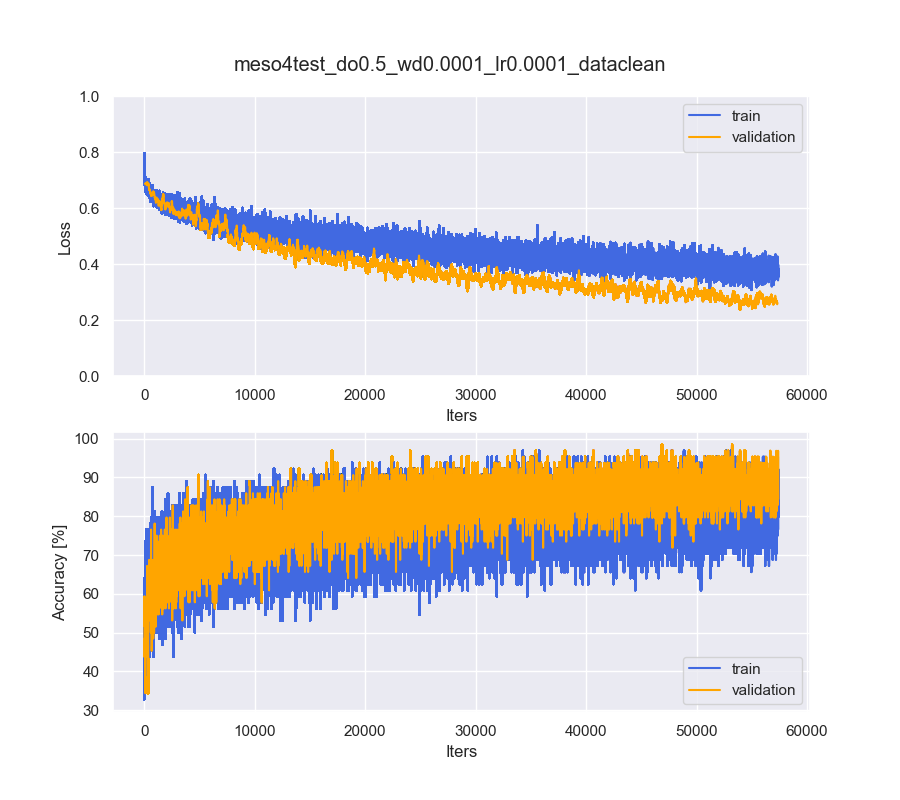

[Epoch: 01/40] [Mean acc train/val: 0.619/0.591] [Mean loss train/val: 0.652/0.654] [F1/Precision/Recall:  0.431/ 0.507/ 0.699]
[Epoch: 02/40] [Mean acc train/val: 0.668/0.664] [Mean loss train/val: 0.612/0.608] [F1/Precision/Recall:  0.551/ 0.633/ 0.765]
[Epoch: 03/40] [Mean acc train/val: 0.688/0.689] [Mean loss train/val: 0.591/0.580] [F1/Precision/Recall:  0.596/ 0.669/ 0.779]
[Epoch: 04/40] [Mean acc train/val: 0.707/0.709] [Mean loss train/val: 0.569/0.560] [F1/Precision/Recall:  0.612/ 0.689/ 0.806]
[Epoch: 05/40] [Mean acc train/val: 0.718/0.732] [Mean loss train/val: 0.553/0.533] [F1/Precision/Recall:  0.648/ 0.718/ 0.819]
[Epoch: 06/40] [Mean acc train/val: 0.729/0.747] [Mean loss train/val: 0.541/0.503] [F1/Precision/Recall:  0.679/ 0.738/ 0.821]
[Epoch: 07/40] [Mean acc train/val: 0.736/0.756] [Mean loss train/val: 0.529/0.495] [F1/Precision/Recall:  0.698/ 0.751/ 0.827]
[Epoch: 08/40] [Mean acc train/val: 0.741/0.764] [Mean loss train/val: 0.522/0.472] [F1/Precision/Recall

In [7]:
# run training
val_loss, val_acc, train_loss, train_acc = run_training(model=model,
                                                        batch_size=batch_size,
                                                        num_epochs=num_epochs,
                                                        train_dataset=trainset,
                                                        device=device,
                                                        title=model_name,
                                                        validation_dataset=valset,
                                                        lr=lr,
                                                        weight_decay=wd,
                                                        show_plots=show_plots,
                                                        num_workers=num_workers,
                                                        log_dir=log_dir,
                                                        reduce_lr_on_plateau=reduce_lr_on_plateau,
                                                        pickup_epoch=0 if not checkpoint else checkpoint+1)

[Test acc: 0.87]


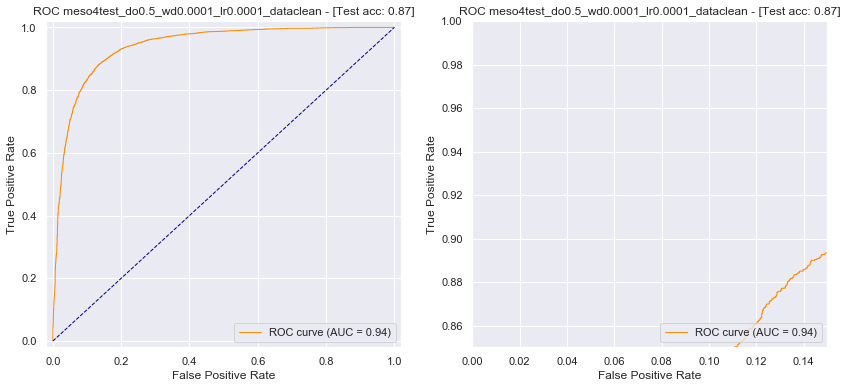

0.8699913269731135

In [8]:
%matplotlib inline
# run eval
evaluate(model=model,
         test_set=testset,
         batch_size=5, 
         title="ROC "+model_name,
         device=device)
